This first block of text simply contains all the libraries that need importing as well as initialising some variables of this example. You may change the batch_size and epochs variables, but should not change num_classes, img_rows and img_cols as these depend on the dataset being used.

In [1]:
!pip install mlxtend --upgrade --no-deps &> /dev/null
from __future__ import print_function
import tensorflow.keras as keras
import tensorflow.keras.datasets as datasets
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mlxtend.plotting import plot_confusion_matrix

batch_size = 128
num_classes = 10
epochs = 30

# input image dimensions
img_rows, img_cols = 32, 32

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

The next block of text handles all the data loading (in this case of the CIFAR-10 dataset) and reshaping so that it can be used to train and evaluate the CNN models. Two sets of data are loaded, the training data, used to generate the model, and the test data, used to evaluate if this model is good at making predictions.

The final set of code of this cell defines the data augmentation pipeline.

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test_orig = y_test
y_test = keras.utils.to_categorical(y_test, num_classes)

# Enable the data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
datagen.fit(x_train)

170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


This cell loads given pre-defined architecture, that had been trained for a different problem. It removes the last layer (because that would be specific to the original problem, and adds some new layers. This process of adapting a network trained on a different problem is called *Transfer Learning*.

The only essential new layer to add is the softmax one (last) that specifies the number of classes of the new dataset.

In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=predictions)

# The rest of this cell is common to both defining the full architecture or using a pre-trained one
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


This is the block of code that trains models and evaluates their predictive capacity on the test data.

The first part prints model's validation accuracy and loss values that are taken from the best model's epoch (one that has the lowest validation loss).

In the second part three performance metrics (precision, recall and F1) are computed for the examples of each of the 10 classes of the dataset, and then averaged. For the definition of these metrics, please see https://en.wikipedia.org/wiki/F-score.

In [4]:
# Enable Early Stopping to prevent model from overfitting
callback=keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto',
    restore_best_weights=True)

# Fits the model on batches with real-time data augmentation
history = model.fit(datagen.flow(x_train, y_train,
         batch_size=batch_size),
         steps_per_epoch=len(x_train) / batch_size,
         epochs=epochs,
         callbacks=[callback],
         validation_data=(x_test, y_test),
         verbose=1)

# Evaluate the model on the test data
val_loss = min(history.history['val_loss'])
epoch = history.history['val_loss'].index(val_loss)
val_accuracy = history.history['val_accuracy'][epoch]


# Display accuracy and loss of the best model
print('Accuracy: %.2f%%' % (val_accuracy * 100), ', Loss: %.2f' % val_loss)
print()

# Print performance metrics
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
print(metrics.classification_report(y_test_orig, predicted_classes, target_names=class_names))

Epoch 1/30
390/390 [==============================] - 68s 85ms/step - loss: 2.2695 - accuracy: 0.1778 - val_loss: 1.3868 - val_accuracy: 0.4757
Epoch 2/30
390/390 [==============================] - 31s 80ms/step - loss: 1.2914 - accuracy: 0.5090 - val_loss: 0.9615 - val_accuracy: 0.6725
Epoch 3/30
390/390 [==============================] - 31s 80ms/step - loss: 0.8590 - accuracy: 0.6964 - val_loss: 0.7166 - val_accuracy: 0.7595
Epoch 4/30
390/390 [==============================] - 31s 80ms/step - loss: 0.6467 - accuracy: 0.7796 - val_loss: 0.6447 - val_accuracy: 0.7873
Epoch 5/30
390/390 [==============================] - 31s 80ms/step - loss: 0.5464 - accuracy: 0.8148 - val_loss: 0.6297 - val_accuracy: 0.7935
Epoch 6/30
390/390 [==============================] - 31s 79ms/step - loss: 0.4922 - accuracy: 0.8356 - val_loss: 0.4797 - val_accuracy: 0.8406
Epoch 7/30
390/390 [==============================] - 31s 79ms/step - loss: 0.4282 - accuracy: 0.8549 - val_loss: 0.4602 - val_accuracy:

Finally, a plot of how the accuracy & loss (measure of the training error of the network) functions changes through the epochs of training and testing are shown.

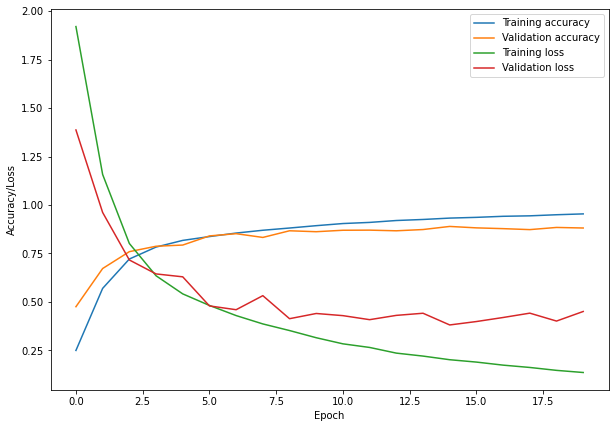

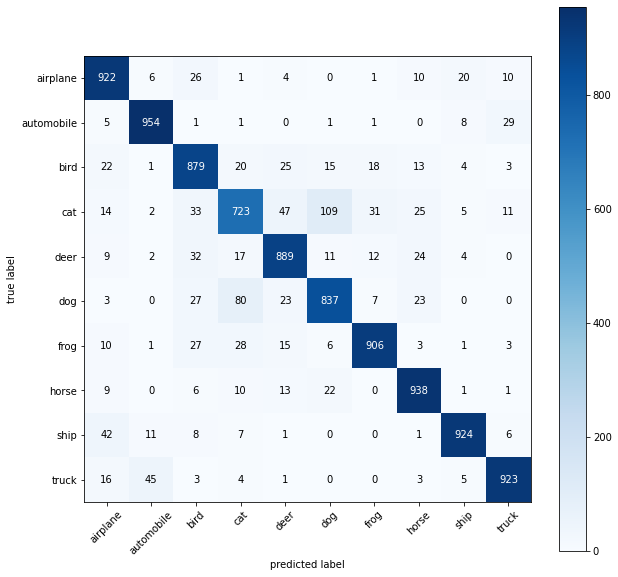

In [5]:
# Plot model accuracy and loss graph
plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Final-model-accuracy-loss.jpg', dpi=200)
plt.show()
print()

# Display confusion matrix
figure, ax = plot_confusion_matrix(conf_mat = metrics.confusion_matrix(y_test_orig, predicted_classes),
                                   class_names = class_names,
                                   show_absolute = True,
                                   colorbar = True,
                                   figsize = (10,10))
plt.savefig('Final-model-confusion-matrix.jpg', dpi=200)
plt.show()

This block of code picks an image from the test set (you can change the index to choose a different image), and shows the probabilities that the CNN model estimates for each class, then shows the actual image.

Probability for class airplane: 0.0000049099
Probability for class automobile: 0.0000039879
Probability for class bird: 0.0000247726
Probability for class cat: 0.0013511508
Probability for class deer: 0.0000224176
Probability for class dog: 0.9984614849
Probability for class frog: 0.0000180042
Probability for class horse: 0.0001115070
Probability for class ship: 0.0000011537
Probability for class truck: 0.0000005848

The winner is dog
The correct class is dog



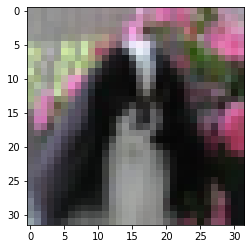

In [6]:
img_index = 42
image = x_test[img_index]

pred=model.predict(np.expand_dims(image, axis=0))[0]
for cl in range(num_classes):
        print("Probability for class {}: {:.10f}".format(class_names[cl],pred[cl]))
print("\nThe winner is {}".format(class_names[np.argmax(pred)]))
print("The correct class is {}\n".format(class_names[np.argmax(y_test[img_index])]))

plt.imshow(image.squeeze(),cmap='viridis')
plt.show()